<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/InsectSAM/Run_InsectSAM_Inference_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run InsectSAM using Transformers 🤗

https://huggingface.co/martintmv/InsectSAM

## Set-up environment

We'll start by installing Transformers and Datasets to import some images on which we'll run the model after.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets

## Load model and processor

Next, let's load the InsectSAM model and its corresponding processor. The model is available on the 🤗 hub.

In [2]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("martintmv/InsectSAM")
model = SamModel.from_pretrained("martintmv/InsectSAM").to(device)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Load image + ground truth map

Next, let's load an image from the dataset colected by [DIOPSIS](https://diopsis.eu/en/) for [RB-IBDM](https://github.com/martintmv-git/RB-IBDM).

In [3]:
from datasets import load_dataset

dataset = load_dataset("martintmv/rb-ibdm-l", split="train")

Generating train split:   0%|          | 0/733 [00:00<?, ? examples/s]

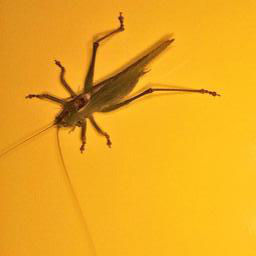

In [4]:
import numpy as np
from PIL import Image

idx = 350

# load image
image = dataset[idx]["image"]
image

The segmentation is a 2D numpy array, indicating with 1's where the region of interest is.

In [5]:
# load ground truth segmentation
ground_truth_seg = np.array(dataset[idx]["label"])
np.unique(ground_truth_seg)

array([0, 1], dtype=int32)

We can visualize this as follows:

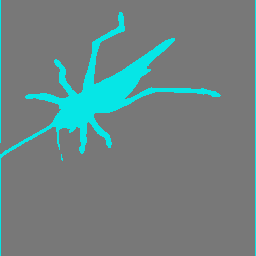

In [6]:
# a random color palette mapping each class to a color (RGB)
palette = [[120, 120, 120], [6, 230, 230]]

color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[ground_truth_seg == label, :] = color

Image.fromarray(color_seg)

## Load box prompt and predict

In [7]:
def get_bounding_box(ground_truth_map):
    # Compute bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    # Ensure the output is a list of list of lists containing floats
    return [[[float(x_min), float(y_min), float(x_max), float(y_max)]]]

input_boxes = get_bounding_box(ground_truth_seg)

# Ensure the input_boxes is correctly formatted for the processor
inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)

# Continue with the rest of your code
for k, v in inputs.items():
    print(k, v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [8]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:

        flattened_box = box[0][0]  # This extracts [x0, y0, x2, y2] from [[[x0, y0, x2, y2]]]
        show_box(flattened_box, plt.gca())

The model is prompted to generate a segmentation mask inside the bounding box.

We can prepare the inputs for the model and perform a forward pass. We move the inputs and model to the GPU if it's available.

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[input_boxes], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [10]:
model.to(device)

# forward pass
# note that the authors use `multimask_output=False` when performing inference
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [11]:
outputs.pred_masks.shape

torch.Size([1, 1, 1, 256, 256])

Note that InsectSAM was fine-tuned using a custom [DiceWithSigmoid loss](https://docs.monai.io/en/1.3.0/metrics.html#), so we need to apply the appropriate postprocessing.

In [12]:
# apply sigmoid
insectsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
insectsam_seg_prob = insectsam_seg_prob.cpu().numpy().squeeze()
insectsam_seg = (insectsam_seg_prob > 0.5).astype(np.uint8)

## Visualize

Let's visualize the predicted mask:

(-0.5, 255.5, 255.5, -0.5)

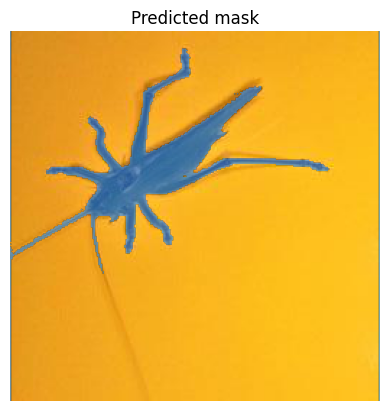

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(insectsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

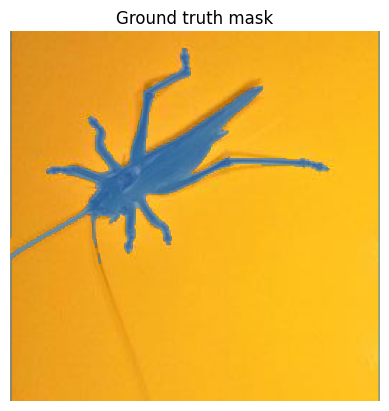

In [14]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")